# Analysis of ATLAS-GAN results

Let's take a look at the results of the DCGAN trained to generate ATLAS RPV SUSY events.

In [1]:
# Convenient fudge for python path
import sys
sys.path.append('..')

In [2]:
# System
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import os
from datetime import datetime

# Externals
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch.autograd import Variable

# Locals
from atlasgan import gan
from atlasgan.dataset import RPVImages, inverse_transform_data, generate_noise
from atlasgan.reco import compute_physics_variables

%matplotlib notebook

In [3]:
def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax, ax=ax)
        cbar.set_label('Energy')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

In [4]:
def draw_reco(sample):
    """Apply reconstruction to one sample and visualize the clusters"""
    jets = build_jets(sample)
    
    # Draw the provided jet image on the left
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    draw_image(sample, vmin=1e-4, ax=axs[0], draw_cbar=False)

    # Draw the jets on the right
    for j in jets:
        s = axs[1].scatter(j.eta, j.phi, s=200, marker='+')
        cl = j.constituents_array()
        axs[1].scatter(cl['eta'], cl['phi'], s=5, marker=',', c=s.get_edgecolor())
        axs[1].set_xlim((-2.5, 2.5))
        axs[1].set_ylim((-np.pi, np.pi))
        axs[1].set_xlabel('$\eta$')
        axs[1].set_ylabel('$\phi$')

    plt.tight_layout()

## Load training results and test data

We don't currently have a separate validation and test dataset, so for now we will do the model selection here on a test dataset.

In [7]:
results_dir = '/data0/sfarrell/atlas_gan/AtlasDCGAN_005'

In [8]:
ls $results_dir

checkpoints/  out.log  README  summaries.npz


In [9]:
# Load the summary data
summaries = np.load(os.path.join(results_dir, 'summaries.npz'))
print(summaries.keys())

['gen_samples', 'd_train_loss', 'd_train_output_real', 'epoch', 'd_train_output_fake', 'g_train_loss']


In [10]:
input_data = '/data0/sfarrell/atlas_rpv_data/RPV10_1400_850_01.npz'

scale = 4e6 #6072947
threshold = 0 #500
n_samples = 4096
noise_dim = 64

In [11]:
dataset = RPVImages(input_data, n_samples=n_samples, scale=scale, from_back=True)

## Training loss and mean outputs

<IPython.core.display.Javascript object>


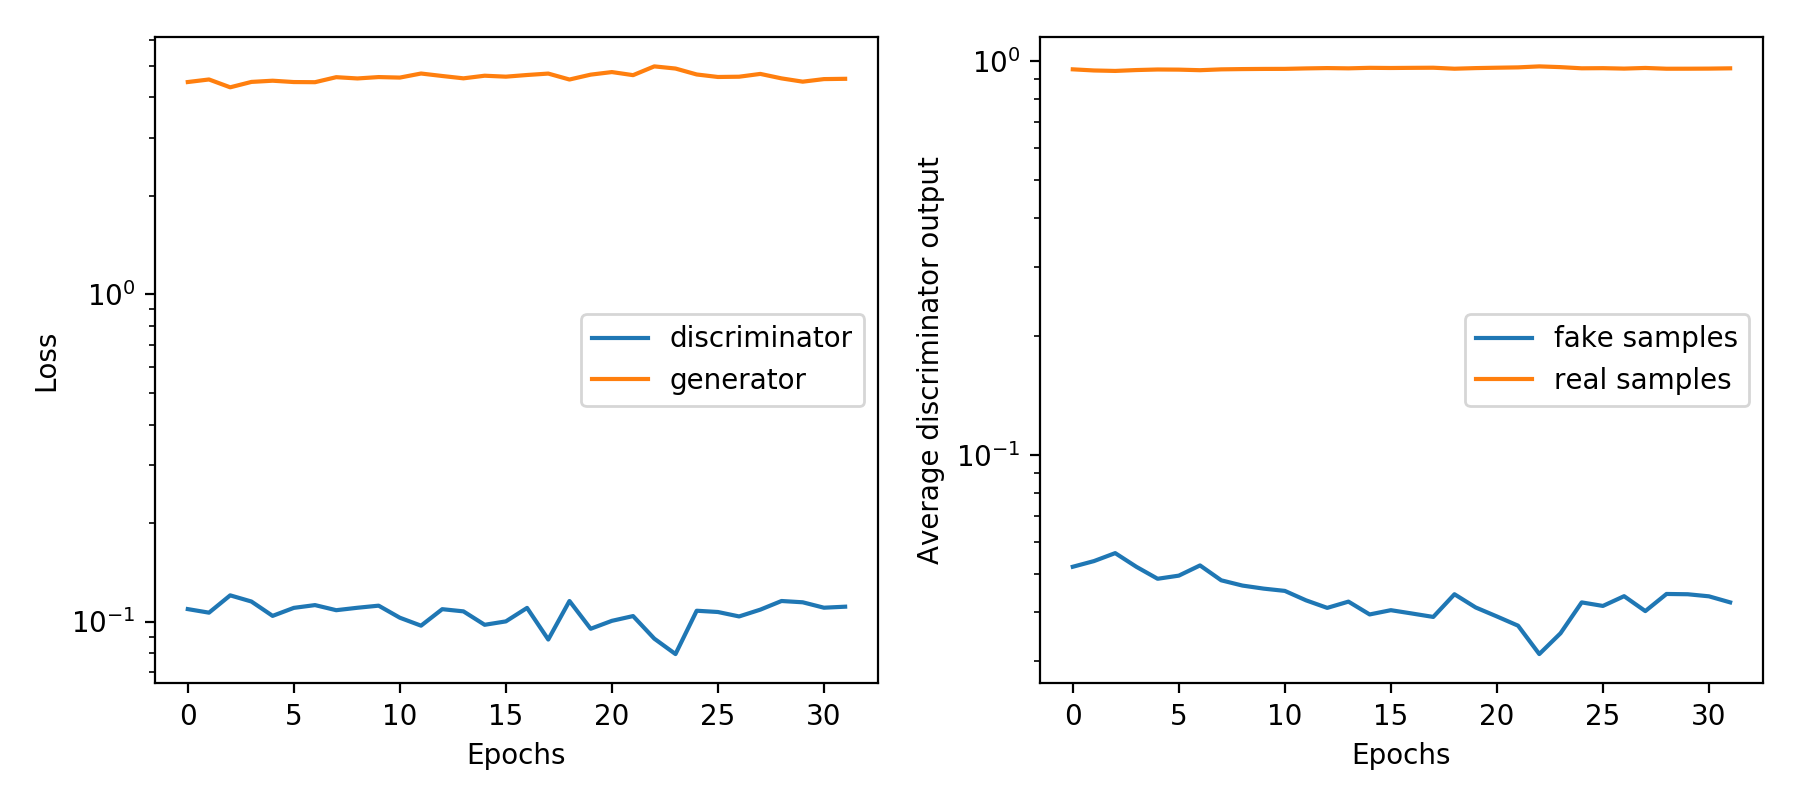

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4))

# Plot training loss
ax0.semilogy(summaries['d_train_loss'], label='discriminator')
ax0.semilogy(summaries['g_train_loss'], label='generator')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

# Plot average discriminator outputs
ax1.semilogy(summaries['d_train_output_fake'], label='fake samples')
ax1.semilogy(summaries['d_train_output_real'], label='real samples')
ax1.legend(loc=0)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Average discriminator output')
plt.tight_layout()

## Compute metrics for every epoch

Loop over epochs, load the checkpoint, generate the samples, compute the metrics.

Oh, but compute the real sample stuff first, of course!

In [13]:
def load_model(results_dir, checkpoint_id, noise_dim=64):
    """Load generator and discriminator from checkpoint"""
    checkpoint_file = os.path.join(
        results_dir, 'checkpoints', 'model_checkpoint_%03i.pth.tar' % checkpoint_id
    )
    checkpoint = torch.load(checkpoint_file)
    generator = gan.Generator(noise_dim)
    discriminator = gan.Discriminator()
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    return generator, discriminator

def ks_metric(x, y):
    return -np.log(scipy.stats.ks_2samp(x, y).pvalue)

In [14]:
# Real images
test_real = Variable(dataset.data, volatile=True)
# Random noise; input for generator
test_noise = Variable(generate_noise(n_samples, noise_dim), volatile=True)
# Get the numpy format of real images
test_images = inverse_transform_data(dataset.data.numpy().squeeze(1), scale, threshold)
# Compute reconstructed physics variables from real images
real_reco_vars = compute_physics_variables(test_images)

In [25]:
%%time

# Initially store all results in an epoch list
results = []

# Loop over epoch checkpoints
for i in summaries['epoch']:
    print(str(datetime.now()), 'Epoch', i)
    
    # Dictionary of results for this epoch
    epoch_results = {}
    epoch_results['epoch'] = i
    
    # Load the model
    generator, discriminator = load_model(results_dir, checkpoint_id=i, noise_dim=noise_dim)
    generator.eval(), discriminator.eval()
    
    # Generated images
    test_fake = generator(test_noise)
    gen_images = inverse_transform_data(test_fake.data.numpy().squeeze(1), scale, threshold)
    epoch_results['gen_images'] = gen_images

    # Apply discriminator to real and fake samples
    dis_real = discriminator(test_real)
    dis_fake = discriminator(test_fake)

    # Save the average discriminator scores
    epoch_results['dis_real'] = dis_real.mean().data[0]
    epoch_results['dis_fake'] = dis_fake.mean().data[0]

    # Compute physics variables on the generated images
    fake_reco_vars = compute_physics_variables(gen_images)
    epoch_results.update(fake_reco_vars)
    
    # Compute KS metrics
    for key in fake_reco_vars.keys():
        epoch_results['ks_' + key] = ks_metric(real_reco_vars[key], fake_reco_vars[key])    
    # Pixel intensity KS metric
    epoch_results['ks_pixel'] = ks_metric(test_images.flatten(), gen_images.flatten())
    
    results.append(epoch_results)

# Pack final results into one dict of arrays
final_results = {}
for key in results[0].keys():
    final_results[key] = np.array([r[key] for r in results])
results = final_results

2018-06-14 23:00:21.802683 Epoch 0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


2018-06-14 23:00:35.488222 Epoch 1
2018-06-14 23:00:48.345865 Epoch 2
2018-06-14 23:01:00.834883 Epoch 3
2018-06-14 23:01:13.991400 Epoch 4
2018-06-14 23:01:27.324935 Epoch 5
2018-06-14 23:01:40.997627 Epoch 6
2018-06-14 23:01:55.567465 Epoch 7
2018-06-14 23:02:08.852751 Epoch 8
2018-06-14 23:02:21.776899 Epoch 9
2018-06-14 23:02:35.411817 Epoch 10
2018-06-14 23:02:48.337219 Epoch 11
2018-06-14 23:03:01.246895 Epoch 12
2018-06-14 23:03:14.523529 Epoch 13
2018-06-14 23:03:27.586753 Epoch 14
2018-06-14 23:03:41.154696 Epoch 15
2018-06-14 23:03:56.375606 Epoch 16
2018-06-14 23:04:11.518064 Epoch 17
2018-06-14 23:04:24.663148 Epoch 18
2018-06-14 23:04:37.519034 Epoch 19
2018-06-14 23:04:50.430393 Epoch 20
2018-06-14 23:05:03.393182 Epoch 21
2018-06-14 23:05:16.377040 Epoch 22
2018-06-14 23:05:32.537828 Epoch 23
2018-06-14 23:05:46.540857 Epoch 24
2018-06-14 23:06:04.152057 Epoch 25
2018-06-14 23:06:17.142006 Epoch 26
2018-06-14 23:06:30.430936 Epoch 27
2018-06-14 23:06:43.483116 Epoch 28
2

In [26]:
# Sum of neg log ks pvalues metric
combined_keys = ['ks_nJet', 'ks_sumMass', 'ks_jetPt']
results['ks_sum'] = sum([results[k] for k in combined_keys])

<IPython.core.display.Javascript object>


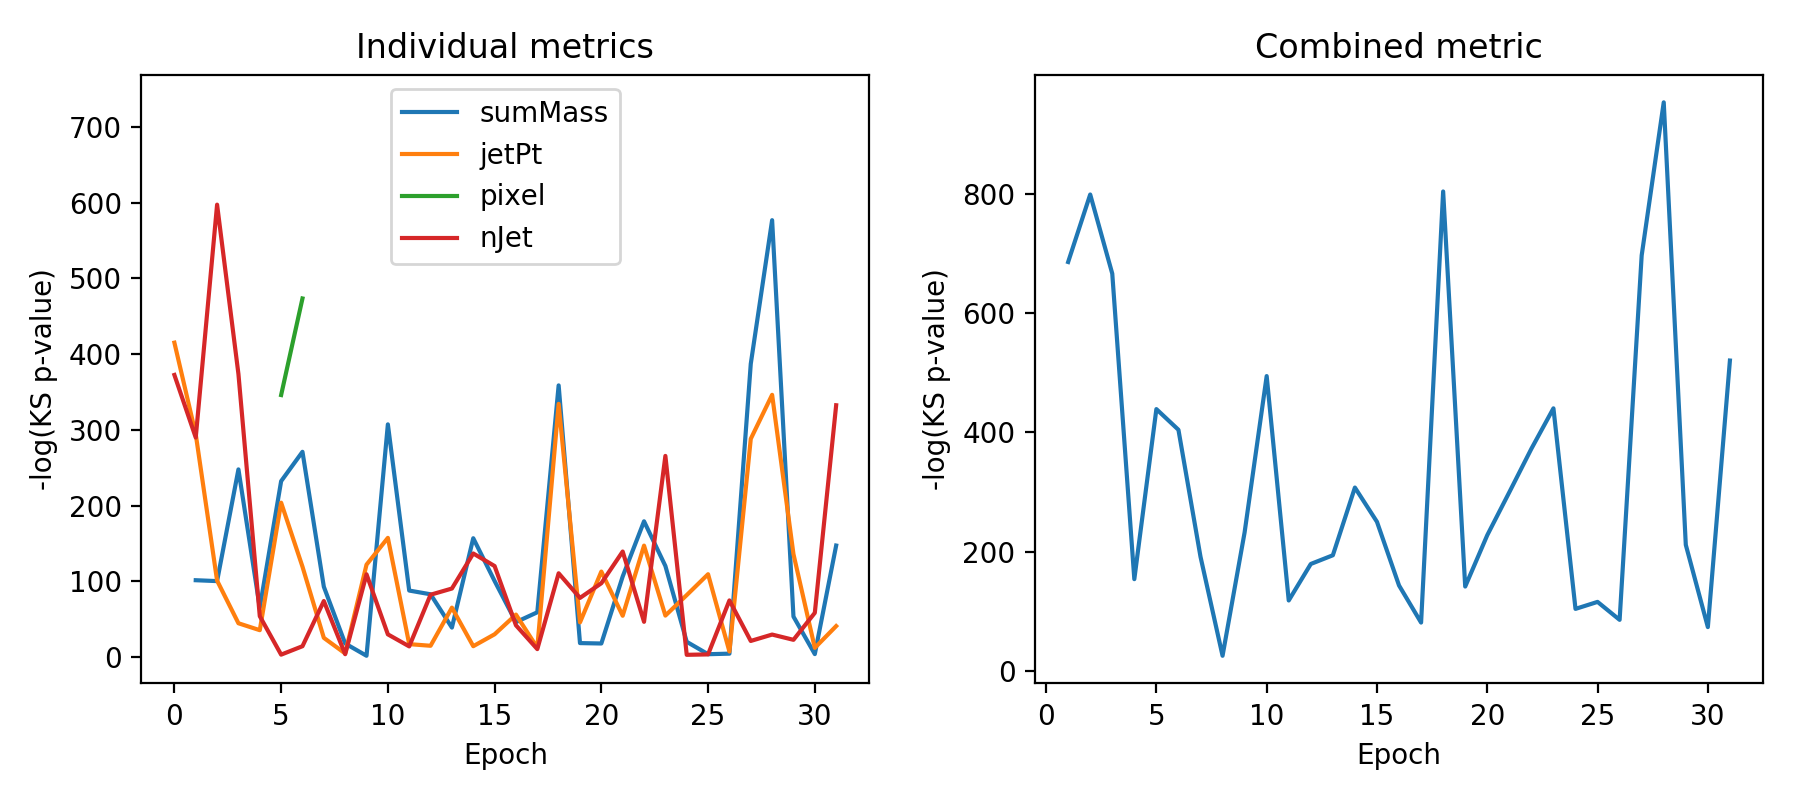

In [28]:
# Plot the physics variable metrics
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))

keys_labels = {
    'ks_pixel': 'pixel',
    'ks_nJet': 'nJet',
    'ks_sumMass': 'sumMass',
    'ks_jetPt': 'jetPt',
    #'ks_jetEta': 'jetEta',
    #'ks_jetPhi': 'jetPhi',
}
for key, label in keys_labels.items():
    ax0.plot(results[key], label=label)
ax0.set_xlabel('Epoch')
ax0.set_ylabel('-log(KS p-value)')
ax0.set_title('Individual metrics')
ax0.legend(loc=0)

# Plot the summed metric separately
ax1.plot(results['ks_sum'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('-log(KS p-value)')
ax1.set_title('Combined metric')

plt.tight_layout()

## Plot kinematics for select epochs

In [30]:
def plot_physics(real_pixels, fake_pixels,
                 real_nJet, fake_nJet,
                 real_sumMass, fake_sumMass,
                 real_pt, fake_pt,
                 real_eta, fake_eta,
                 real_phi, fake_phi,
                 figsize=(9, 6), linewidth=1):
    
    fig1, axs = plt.subplots(2, 3, figsize=(9, 6))
    (ax0, ax1, ax2), (ax3, ax4, ax5) = axs
    
    # Pixel energy
    hist_args = dict(bins=100, range=(0, 1e3), log=True, histtype='step', linewidth=linewidth)
    ax0.hist(real_pixels.flatten()*1e-3, label='real', **hist_args)
    ax0.hist(fake_pixels.flatten()*1e-3, label='fake', **hist_args)
    ax0.set_xlabel('Pixel energy [GeV]')
    ax0.legend(loc=0)
    
    # Jet multiplicity
    hist_args = dict(bins=10, range=(0, 10), log=False, histtype='step', linewidth=linewidth)
    ax1.hist(real_nJet, label='real', **hist_args)
    ax1.hist(fake_nJet, label='fake', **hist_args)
    ax1.set_xlabel('Number of jets')
    ax1.legend(loc=0)

    # Sum of jet mass
    hist_args = dict(bins=20, range=(0, 2e3), log=False, histtype='step', linewidth=linewidth)
    ax2.hist(real_sumMass*1e-3, label='real', **hist_args)
    ax2.hist(fake_sumMass*1e-3, label='fake', **hist_args)
    ax2.set_xlabel('Sum of jet mass [GeV]')
    ax2.legend(loc=0)
    
    # Jet PT
    hist_args = dict(bins=20, range=(0, 2e3), histtype='step', linewidth=linewidth, log=False)
    ax3.hist(real_pt*1e-3, label='real', **hist_args)
    ax3.hist(fake_pt*1e-3, label='fake', **hist_args)
    ax3.set_xlabel('Jet $p_T$ [GeV]')
    ax3.legend(loc=0)

    # Jet eta
    hist_args = dict(bins=20, range=(-2, 2), histtype='step', linewidth=linewidth)
    ax4.hist(real_eta, label='real', **hist_args)
    ax4.hist(fake_eta, label='fake', **hist_args)
    ax4.set_xlabel('Jet $\eta$')
    ax4.legend(loc=0)

    # Jet phi
    hist_args = dict(bins=20, range=(-np.pi, np.pi), histtype='step', linewidth=linewidth)
    ax5.hist(real_phi, label='real', **hist_args)
    ax5.hist(fake_phi, label='fake', **hist_args)
    ax5.set_xlabel('Jet $\phi$')
    ax5.legend(loc=0)

    plt.tight_layout()

In [31]:
# Which epochs were the best for certain metrics?
for key in ['ks_nJet', 'ks_pixel', 'ks_sumMass', 'ks_jetPt', 'ks_jetEta', 'ks_jetPhi', 'ks_sum']:
    print(key, results[key].argmin())

ks_nJet 24
ks_pixel 23
ks_sumMass 9
ks_jetPt 8
ks_jetEta 12
ks_jetPhi 10
ks_sum 8


Epoch 0


<IPython.core.display.Javascript object>


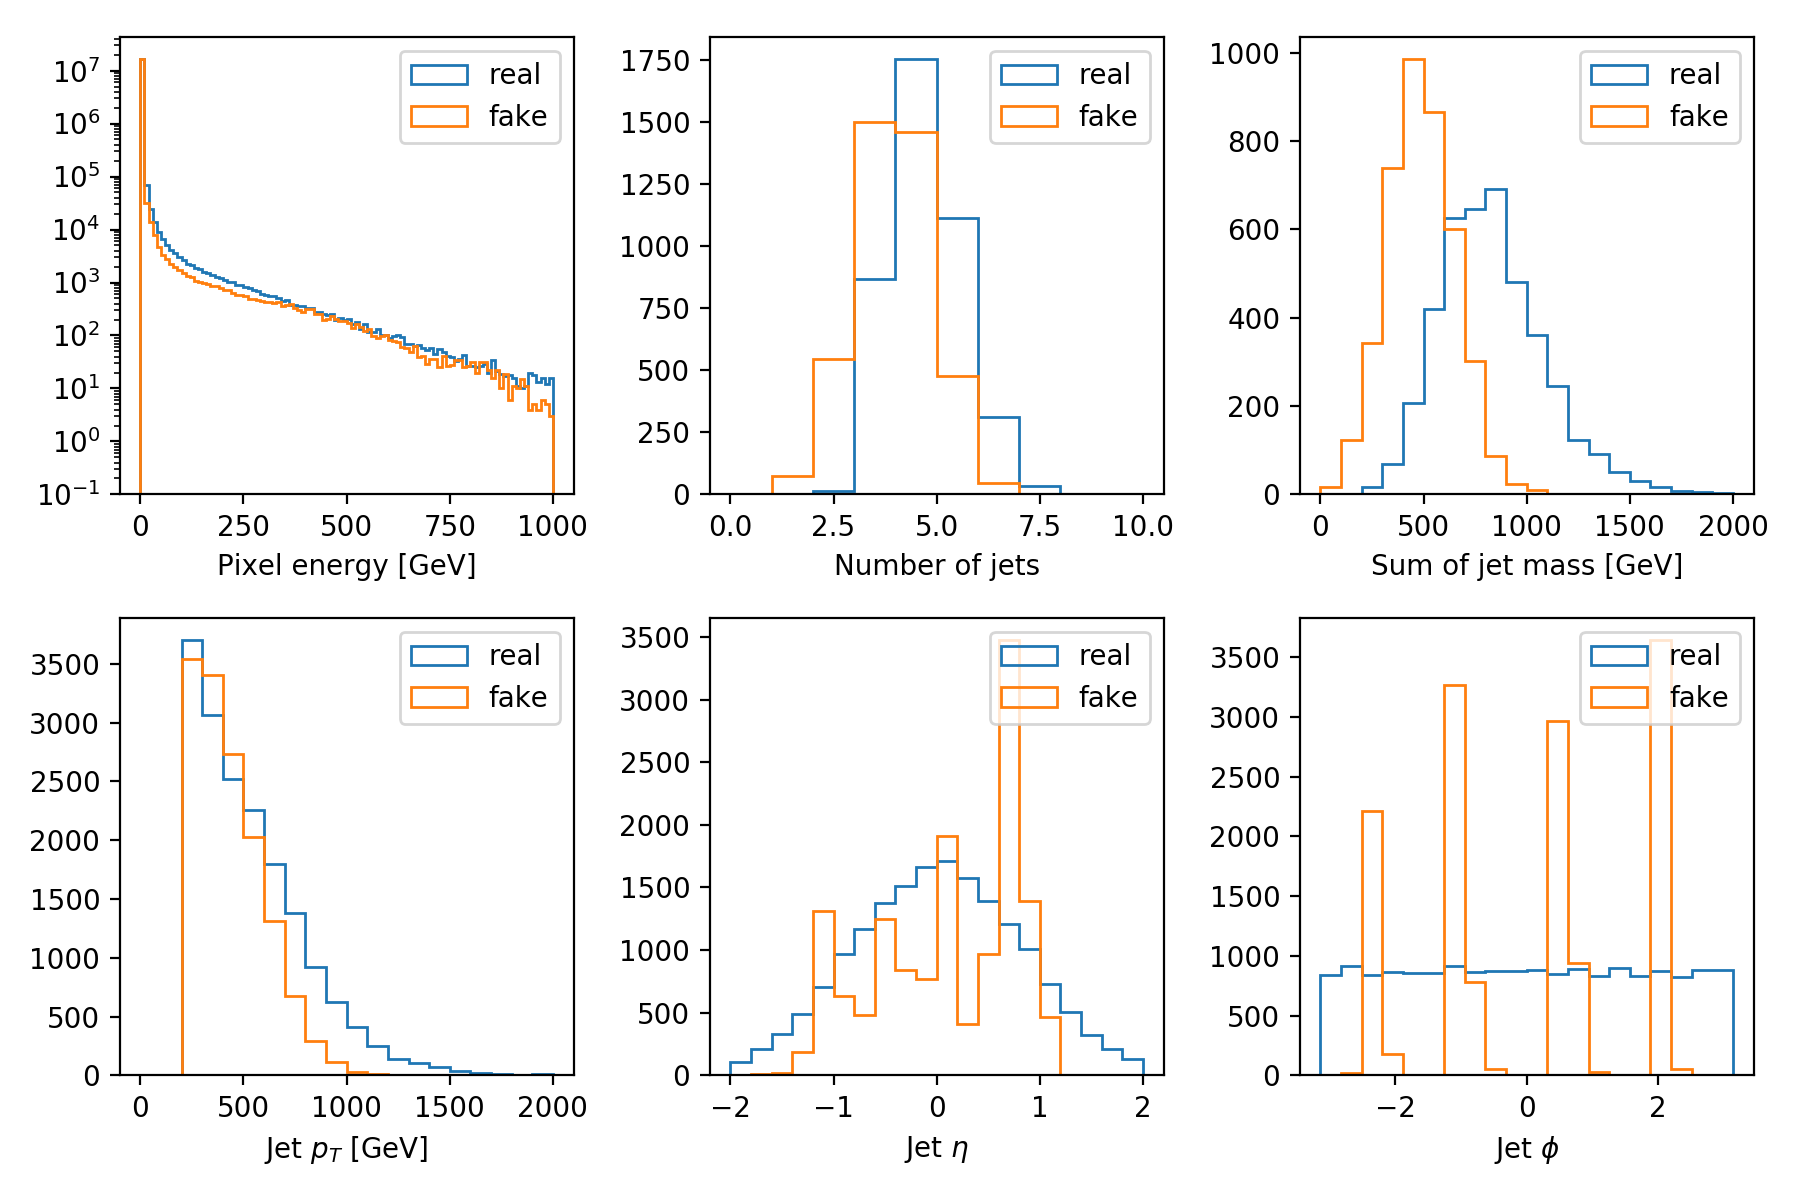

Epoch 8


<IPython.core.display.Javascript object>


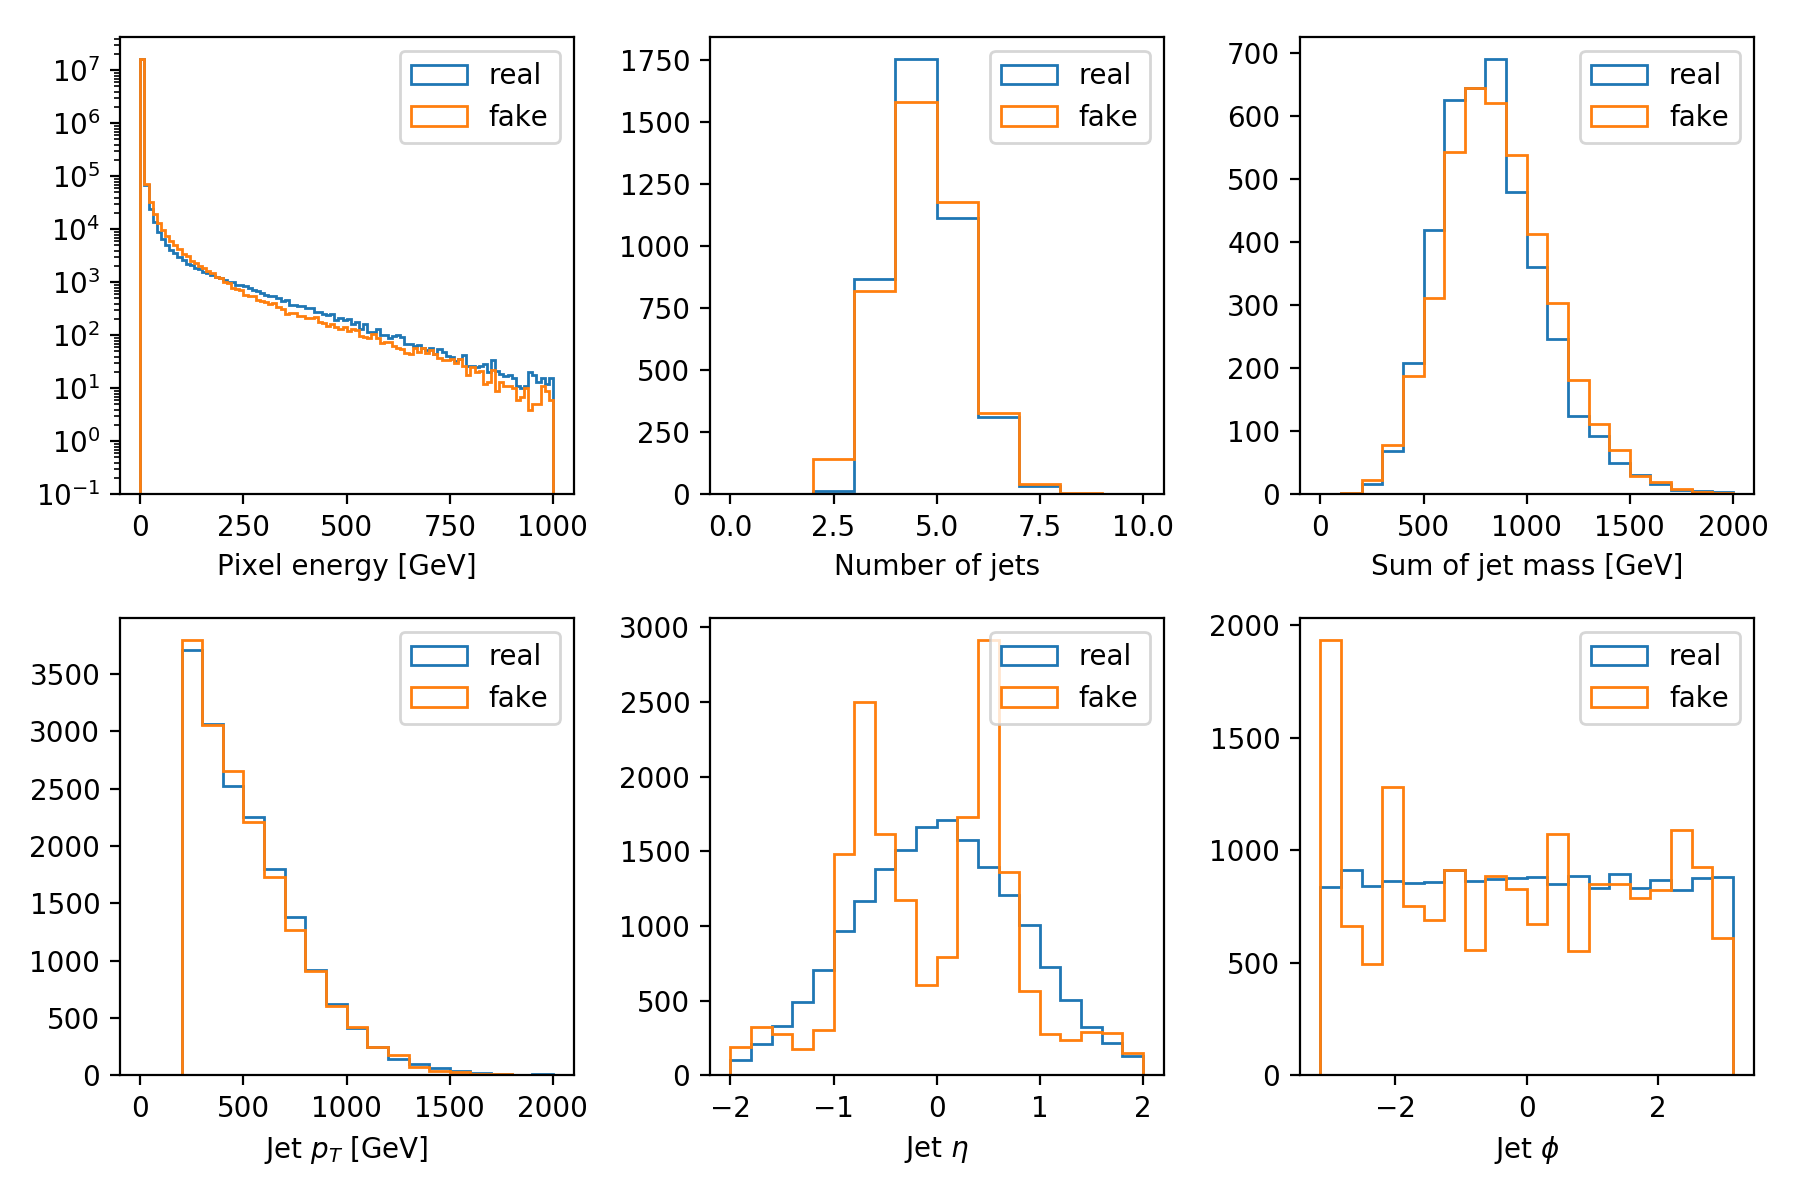

Epoch 9


<IPython.core.display.Javascript object>


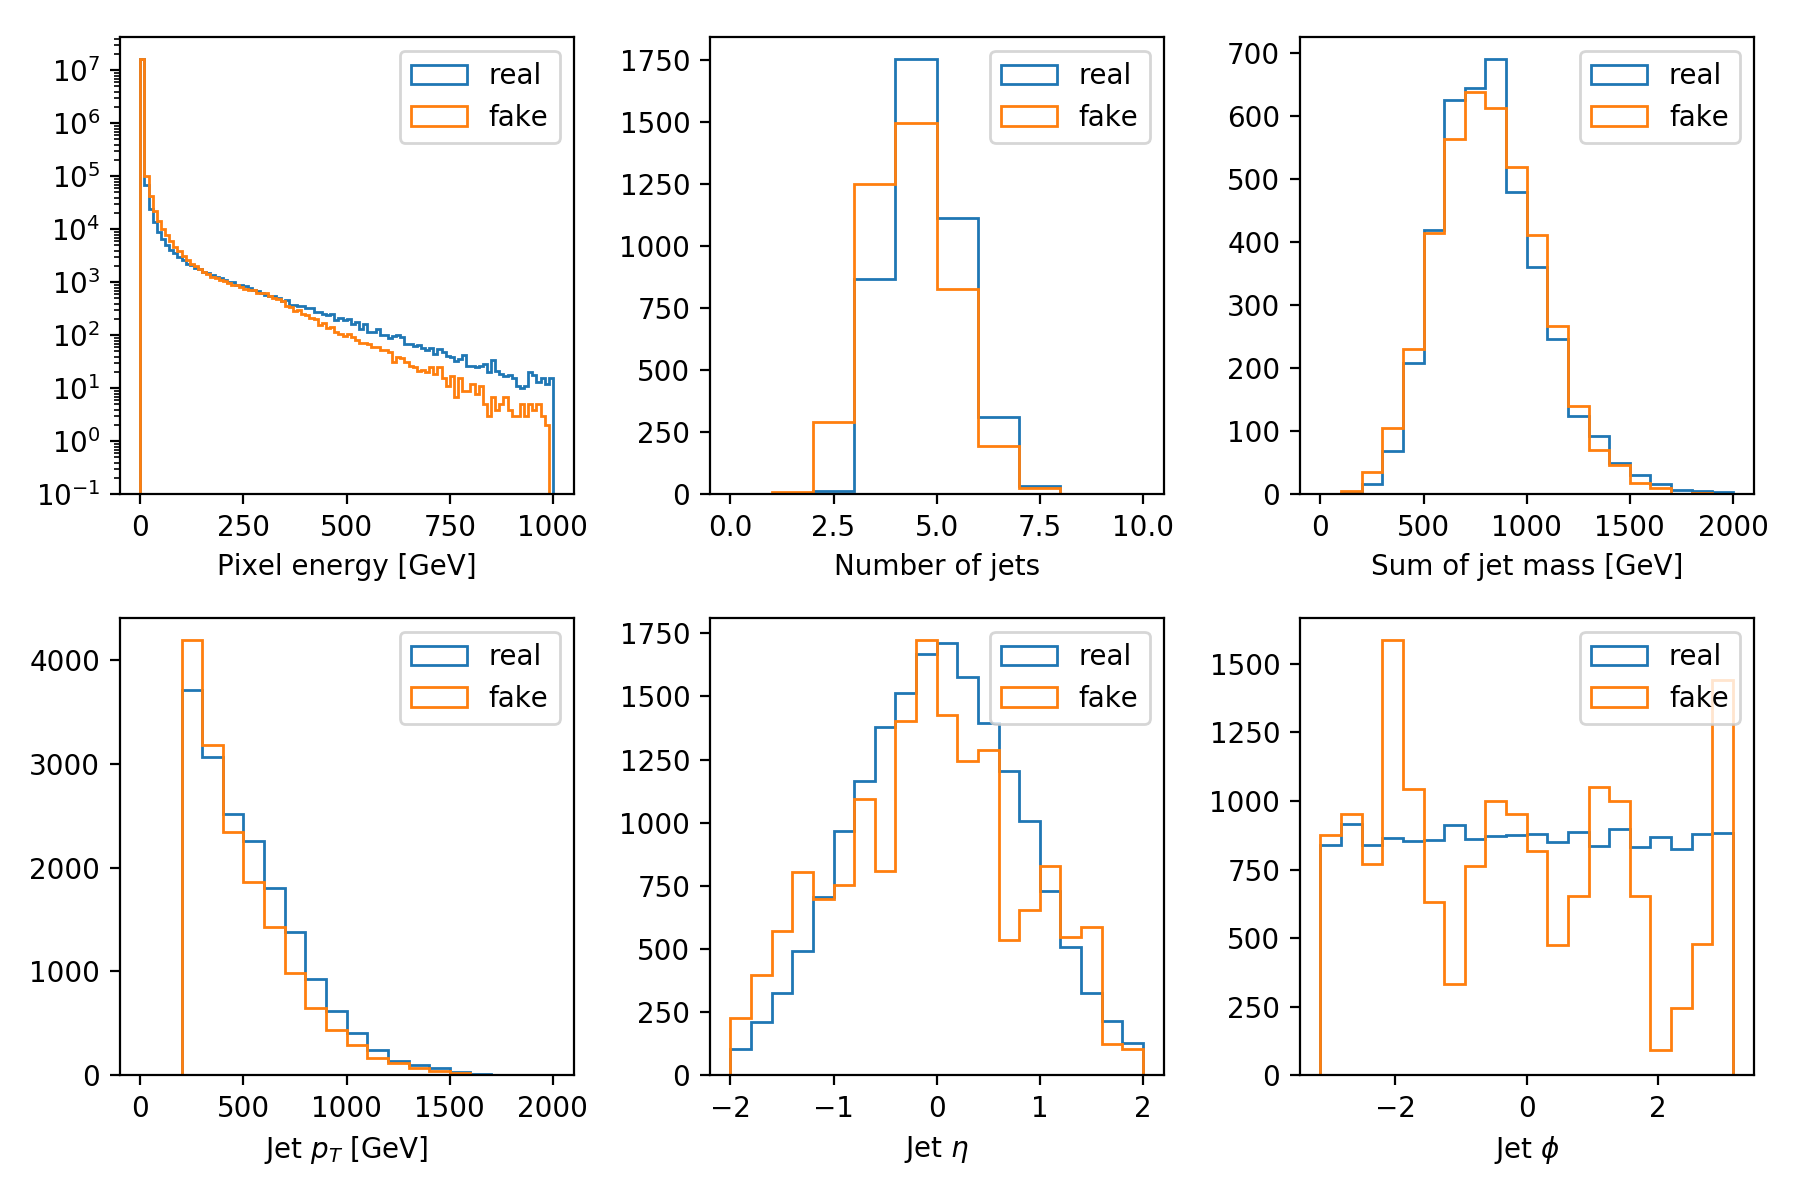

Epoch 10


<IPython.core.display.Javascript object>


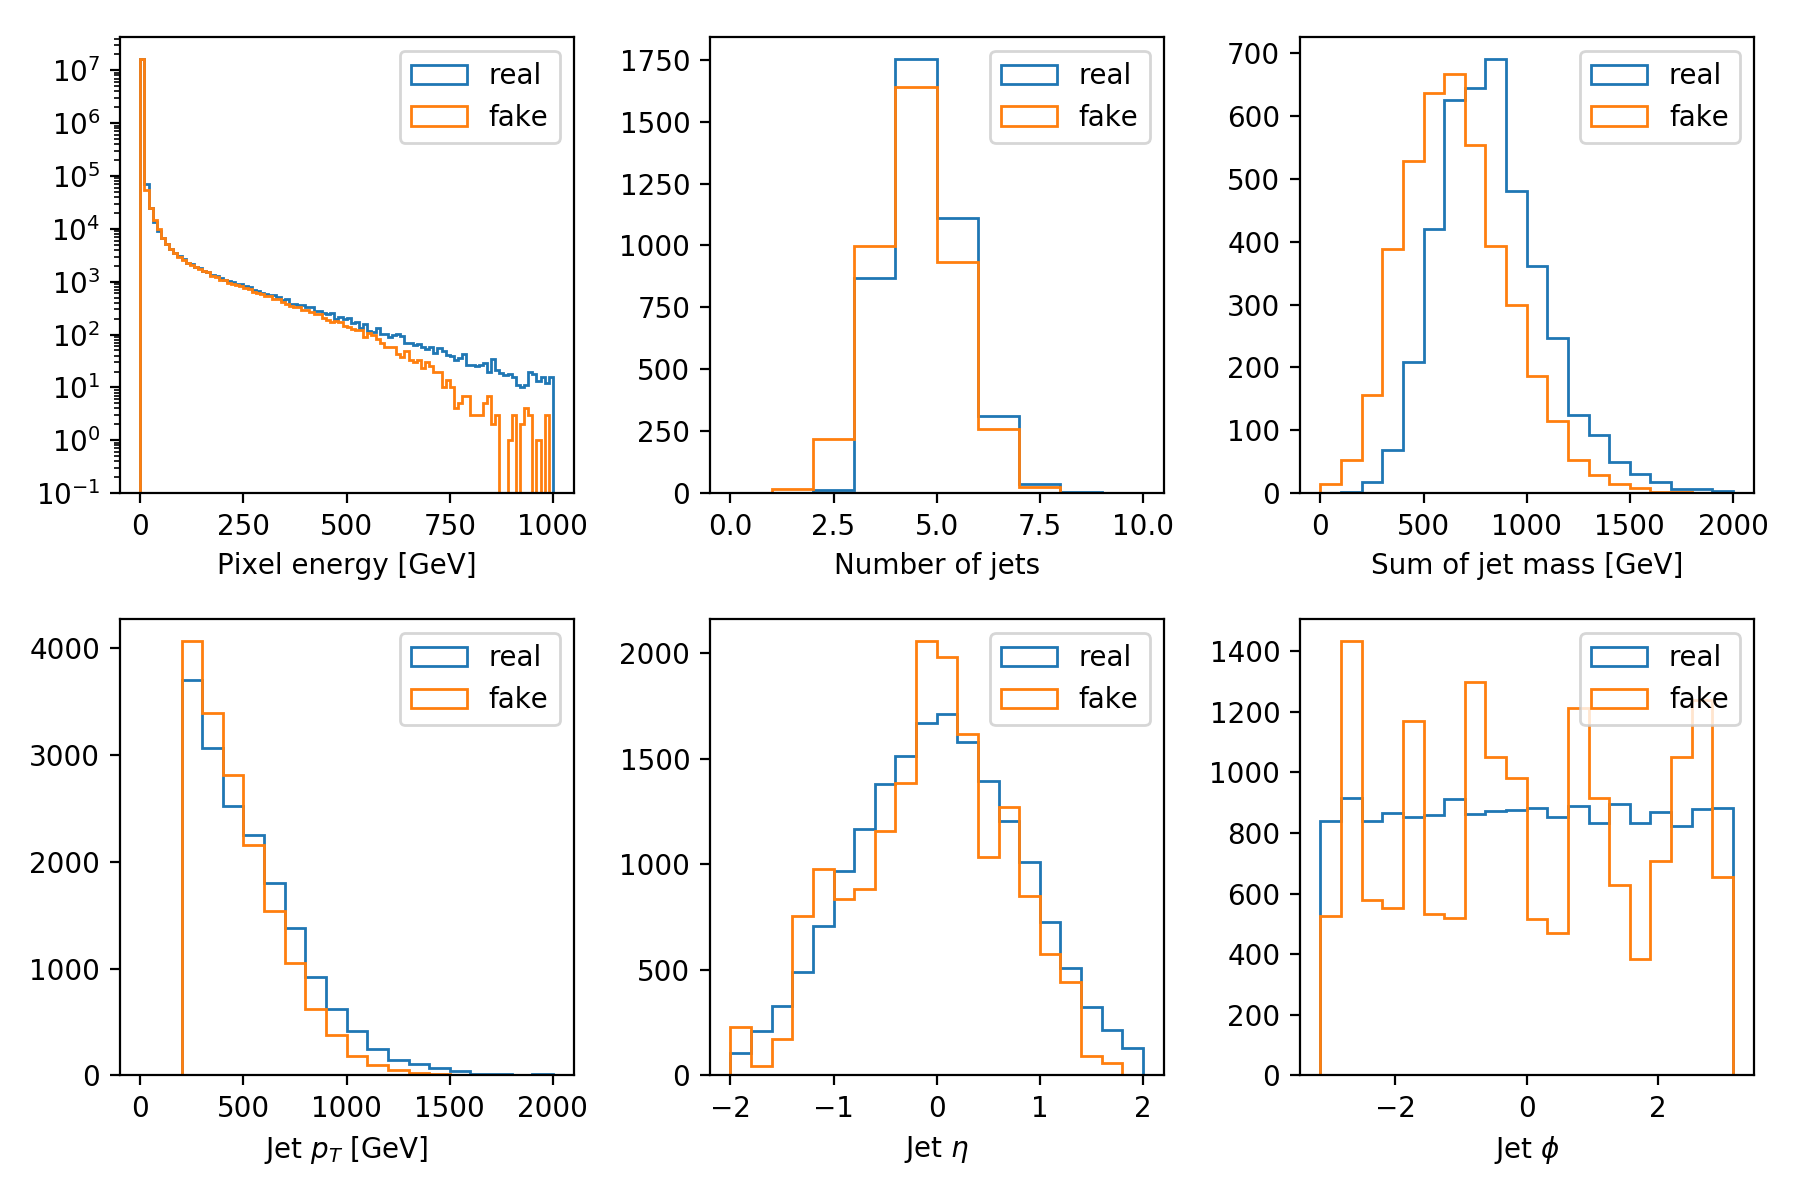

Epoch 23


<IPython.core.display.Javascript object>


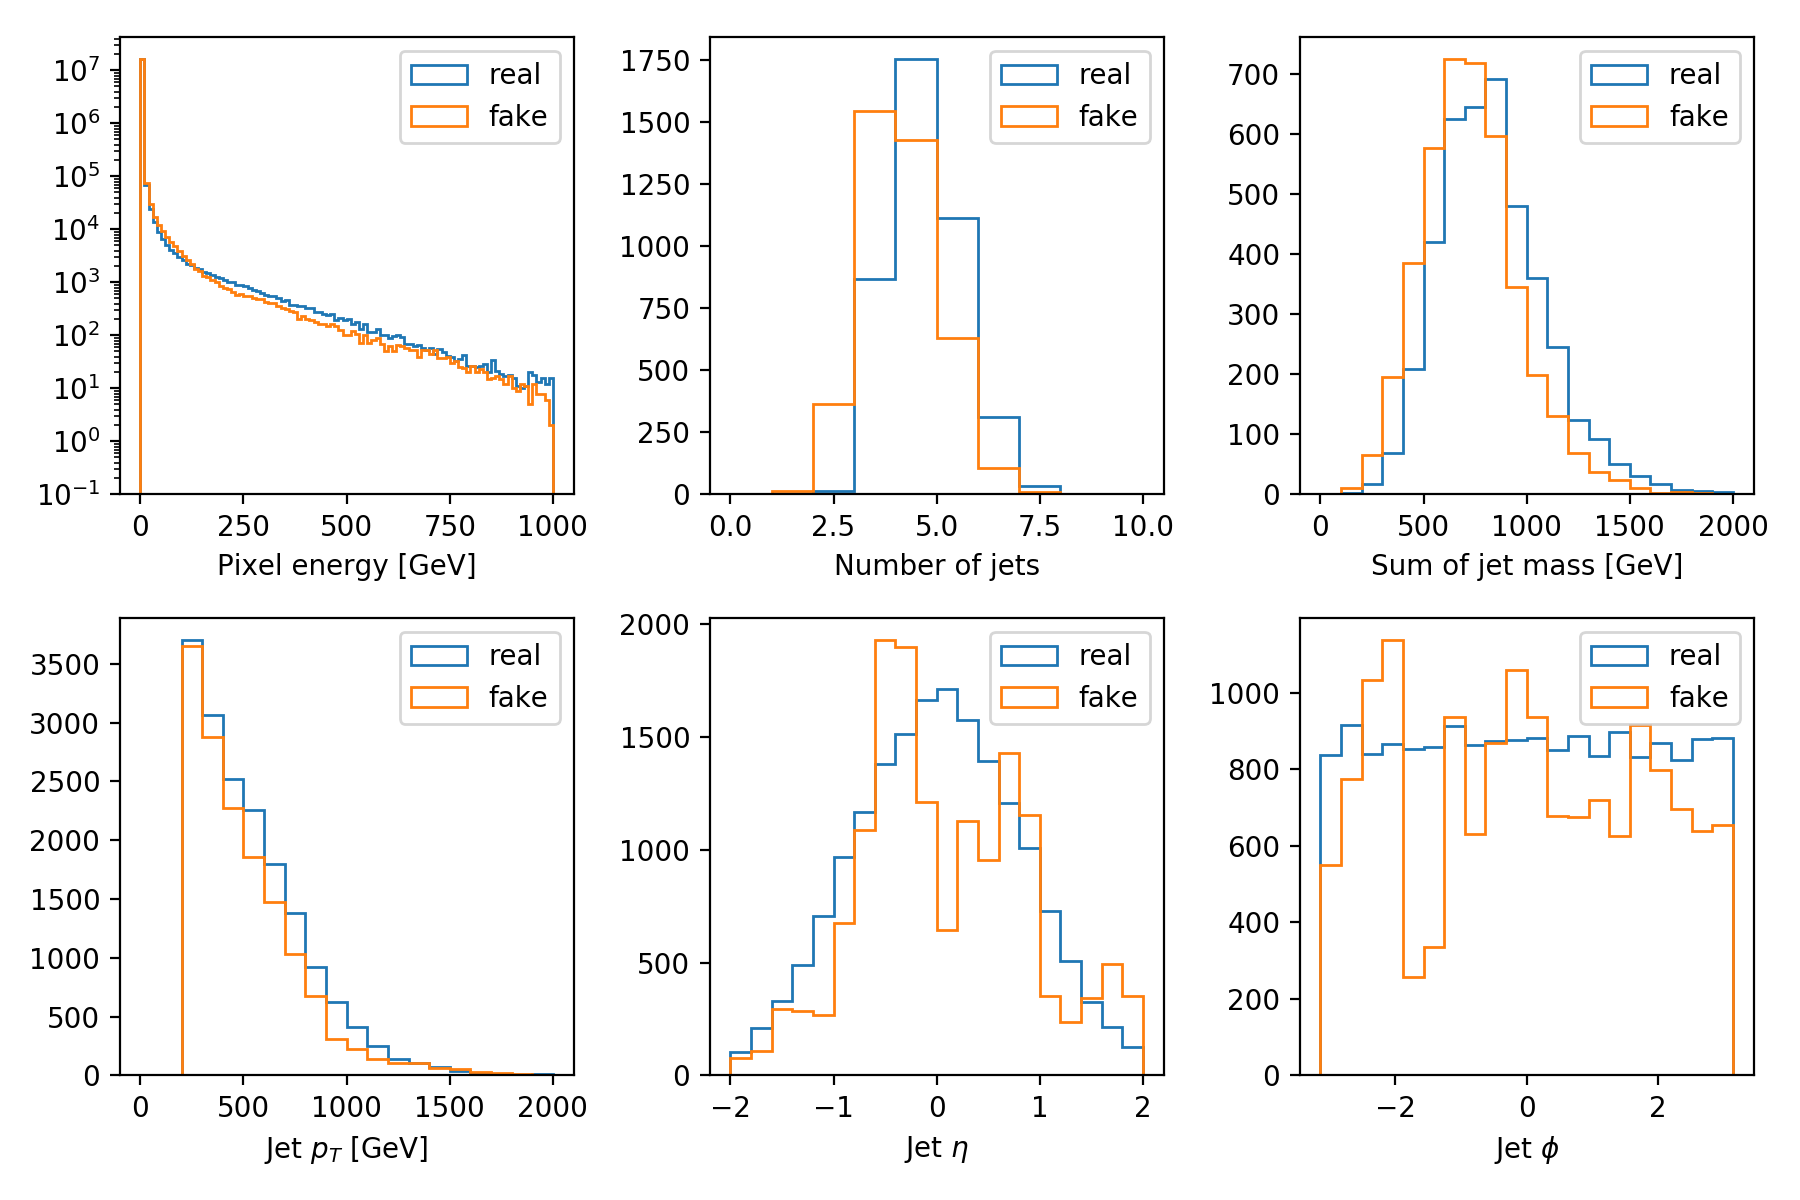

Epoch 24


<IPython.core.display.Javascript object>


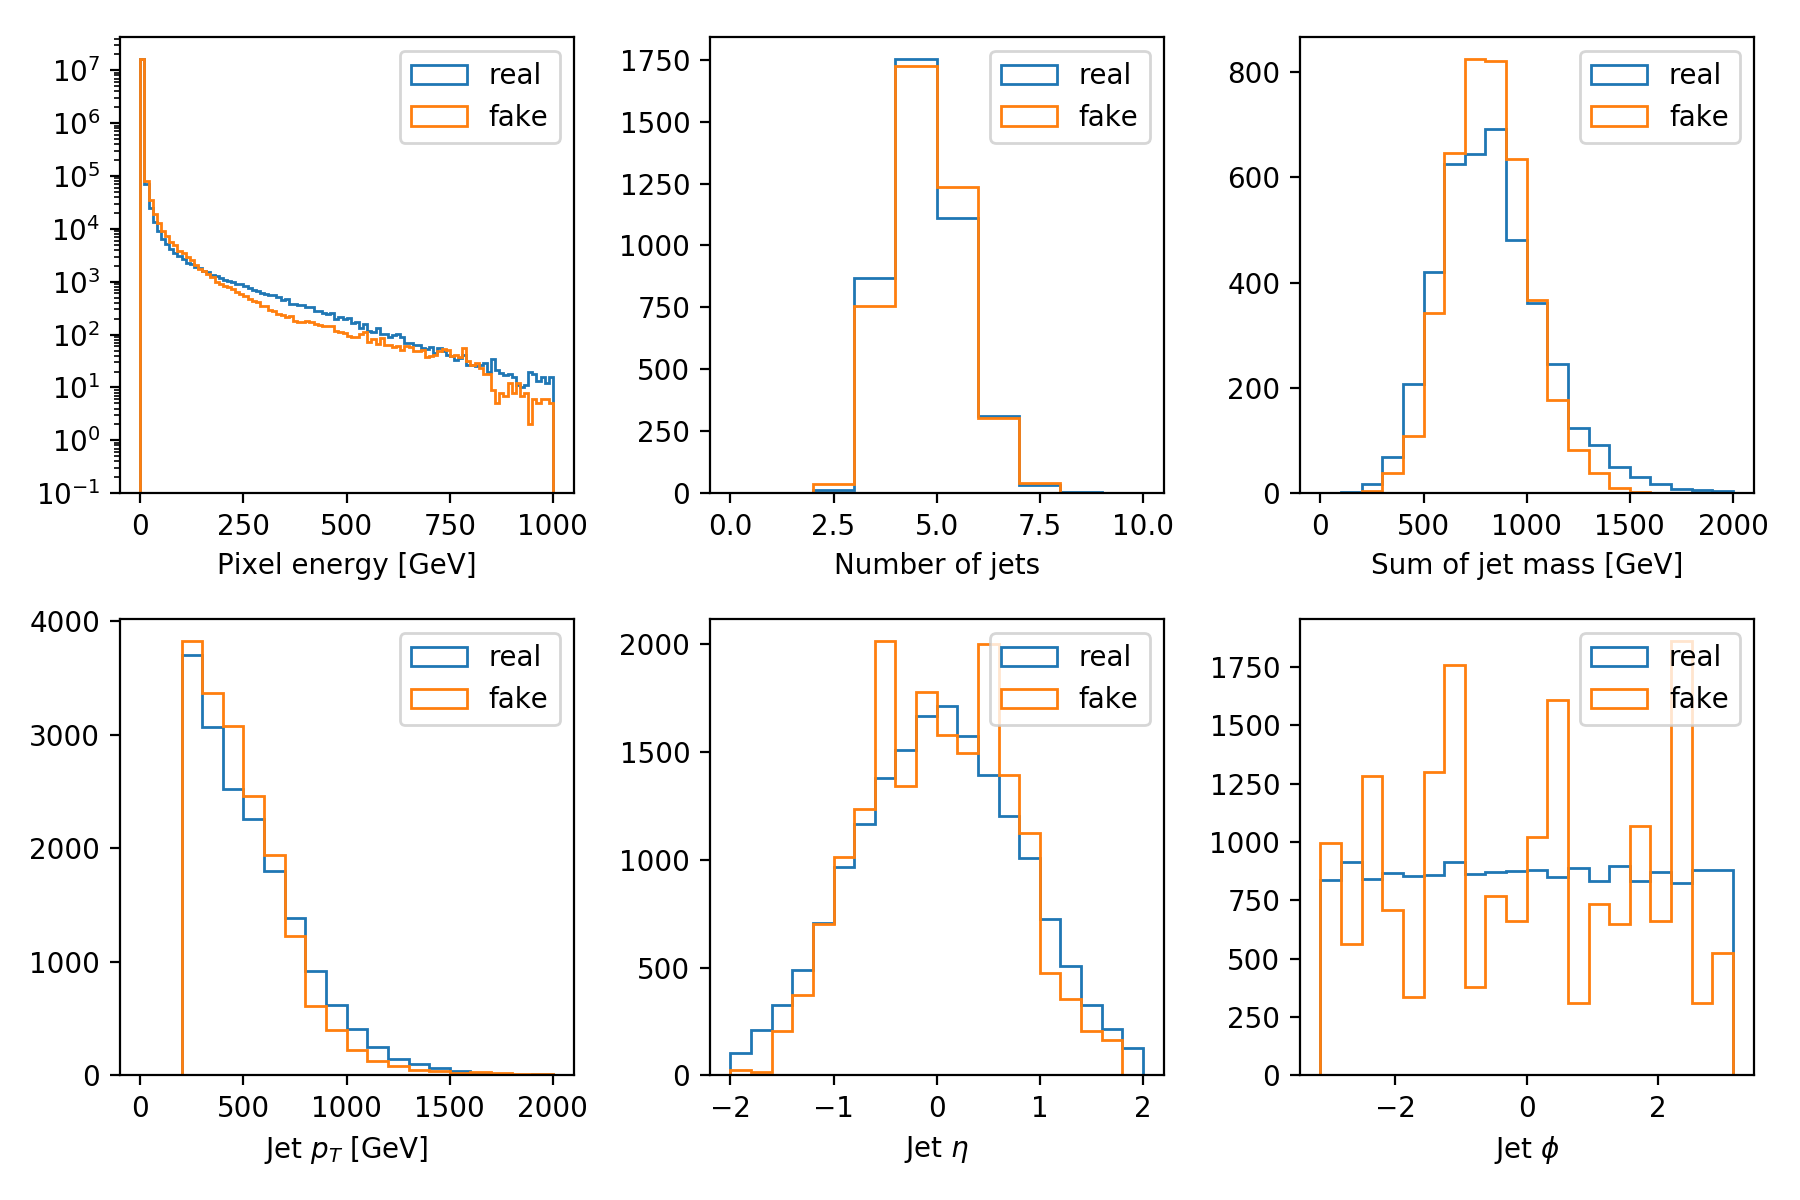

Epoch 31


<IPython.core.display.Javascript object>


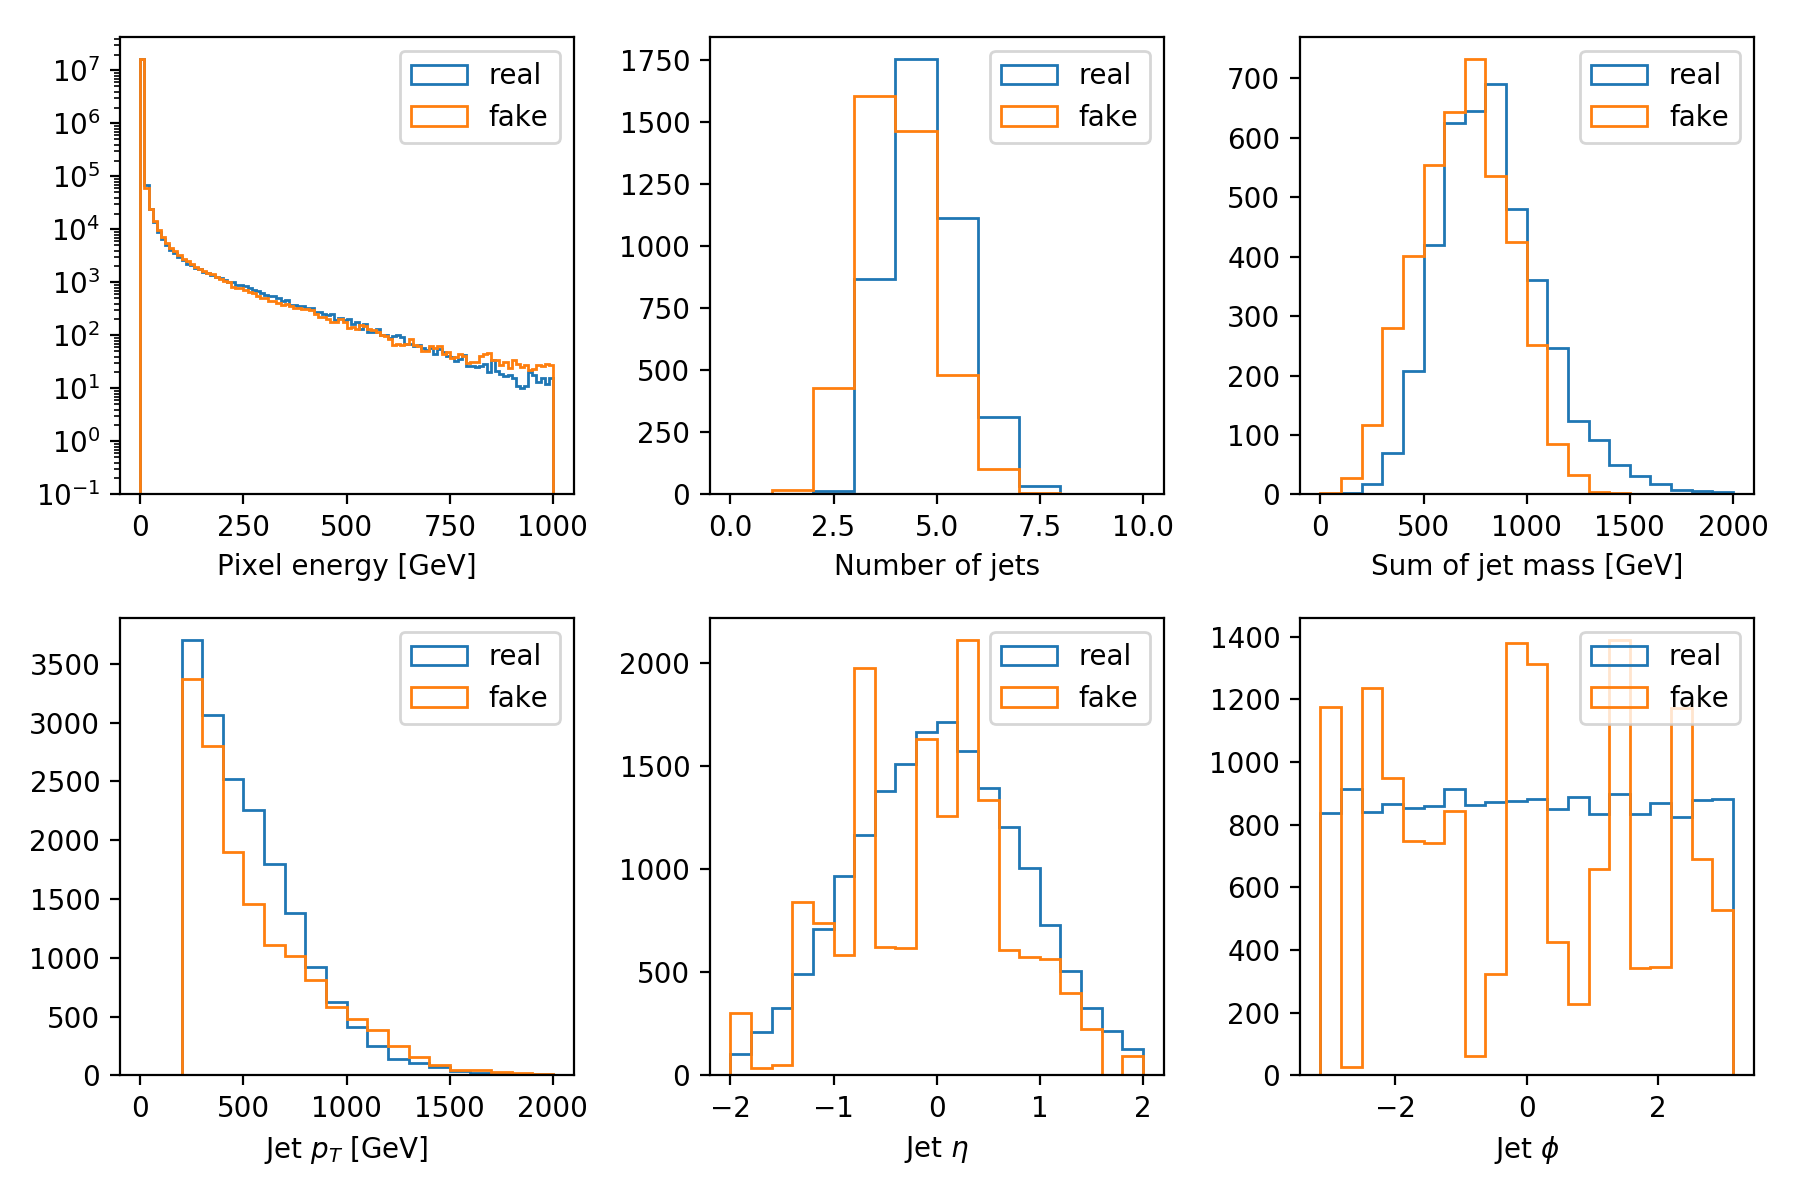

In [33]:
# Manually including the 'best' ones for the above variables
select_epochs = [0, 8, 9, 10, 23, 24, 31]
for i in select_epochs:
    print('Epoch', i)
    plot_physics(test_images, results['gen_images'][i],
             real_reco_vars['nJet'], results['nJet'][i],
             real_reco_vars['sumMass'], results['sumMass'][i],
             real_reco_vars['jetPt'], results['jetPt'][i],
             real_reco_vars['jetEta'], results['jetEta'][i],
             real_reco_vars['jetPhi'], results['jetPhi'][i])

## View sample images from a select epochs

<IPython.core.display.Javascript object>


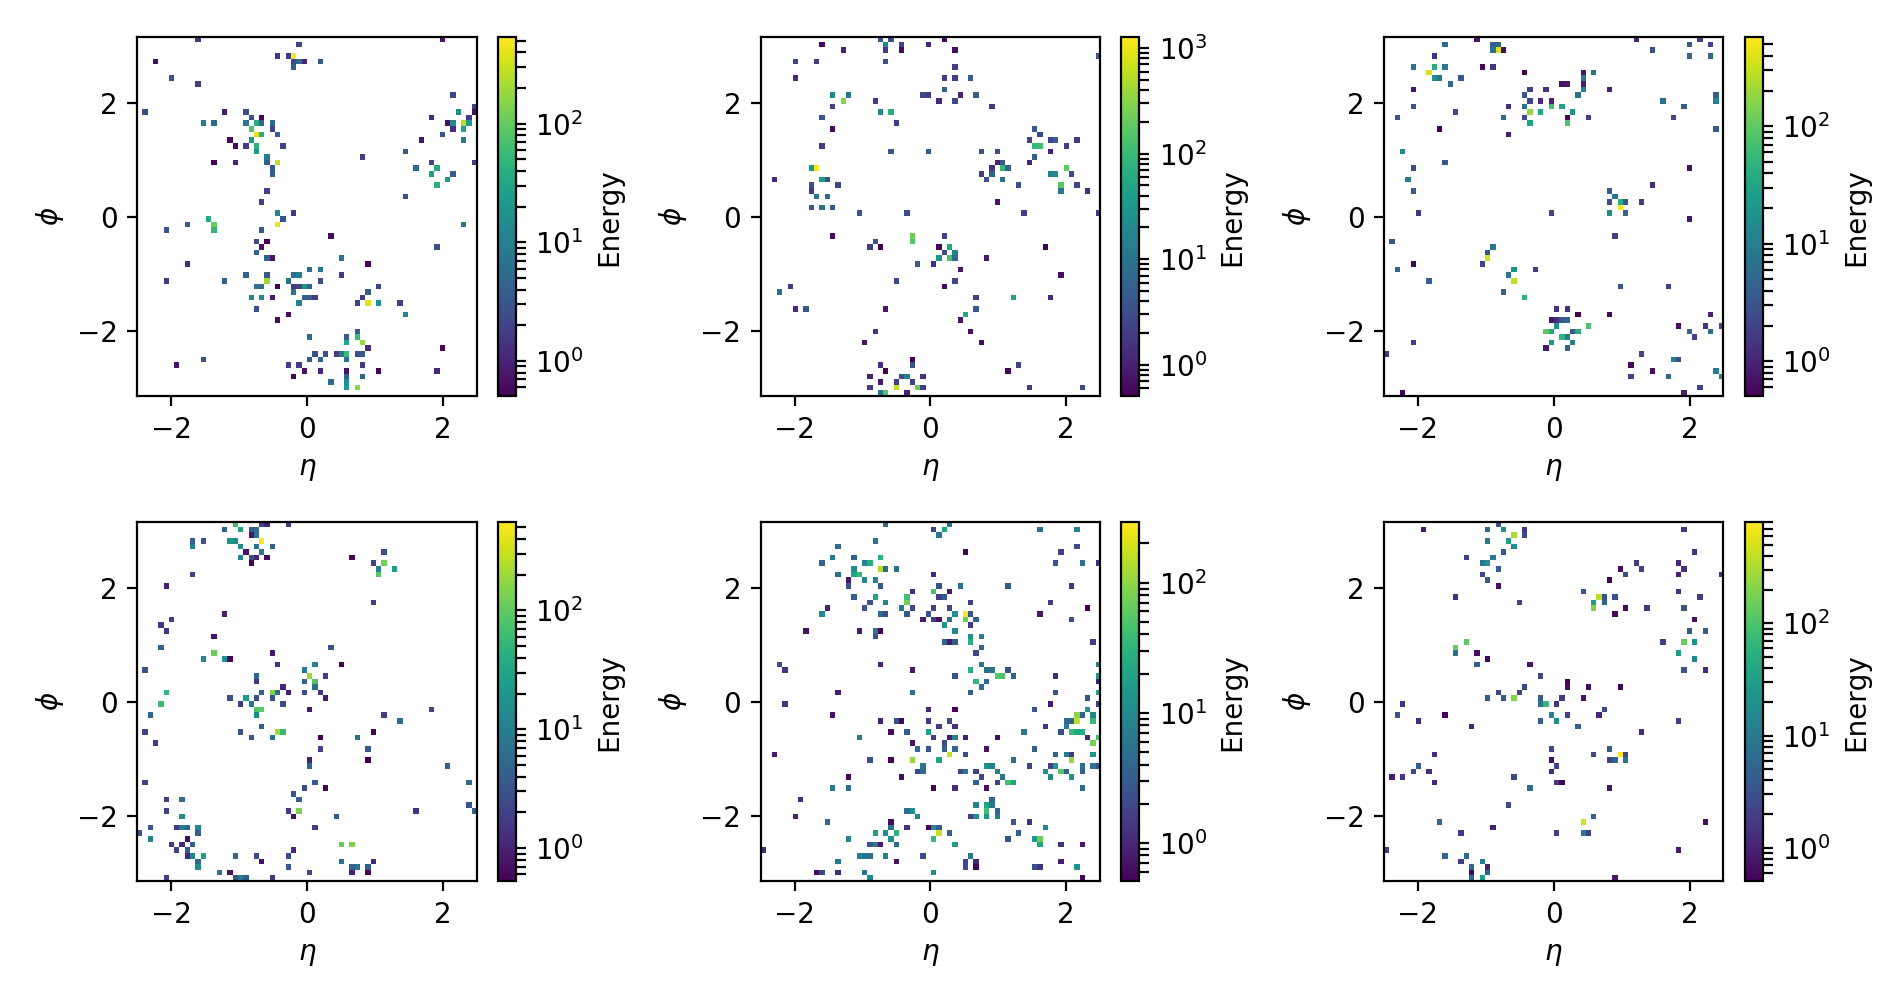

In [34]:
# Real images
fig, axs = plt.subplots(2, 3, figsize=(9.5, 5))
for i, ax in enumerate(axs.flatten()):
    draw_image(test_images[i]*1e-3, ax=ax)
plt.tight_layout()

Epoch 0


<IPython.core.display.Javascript object>


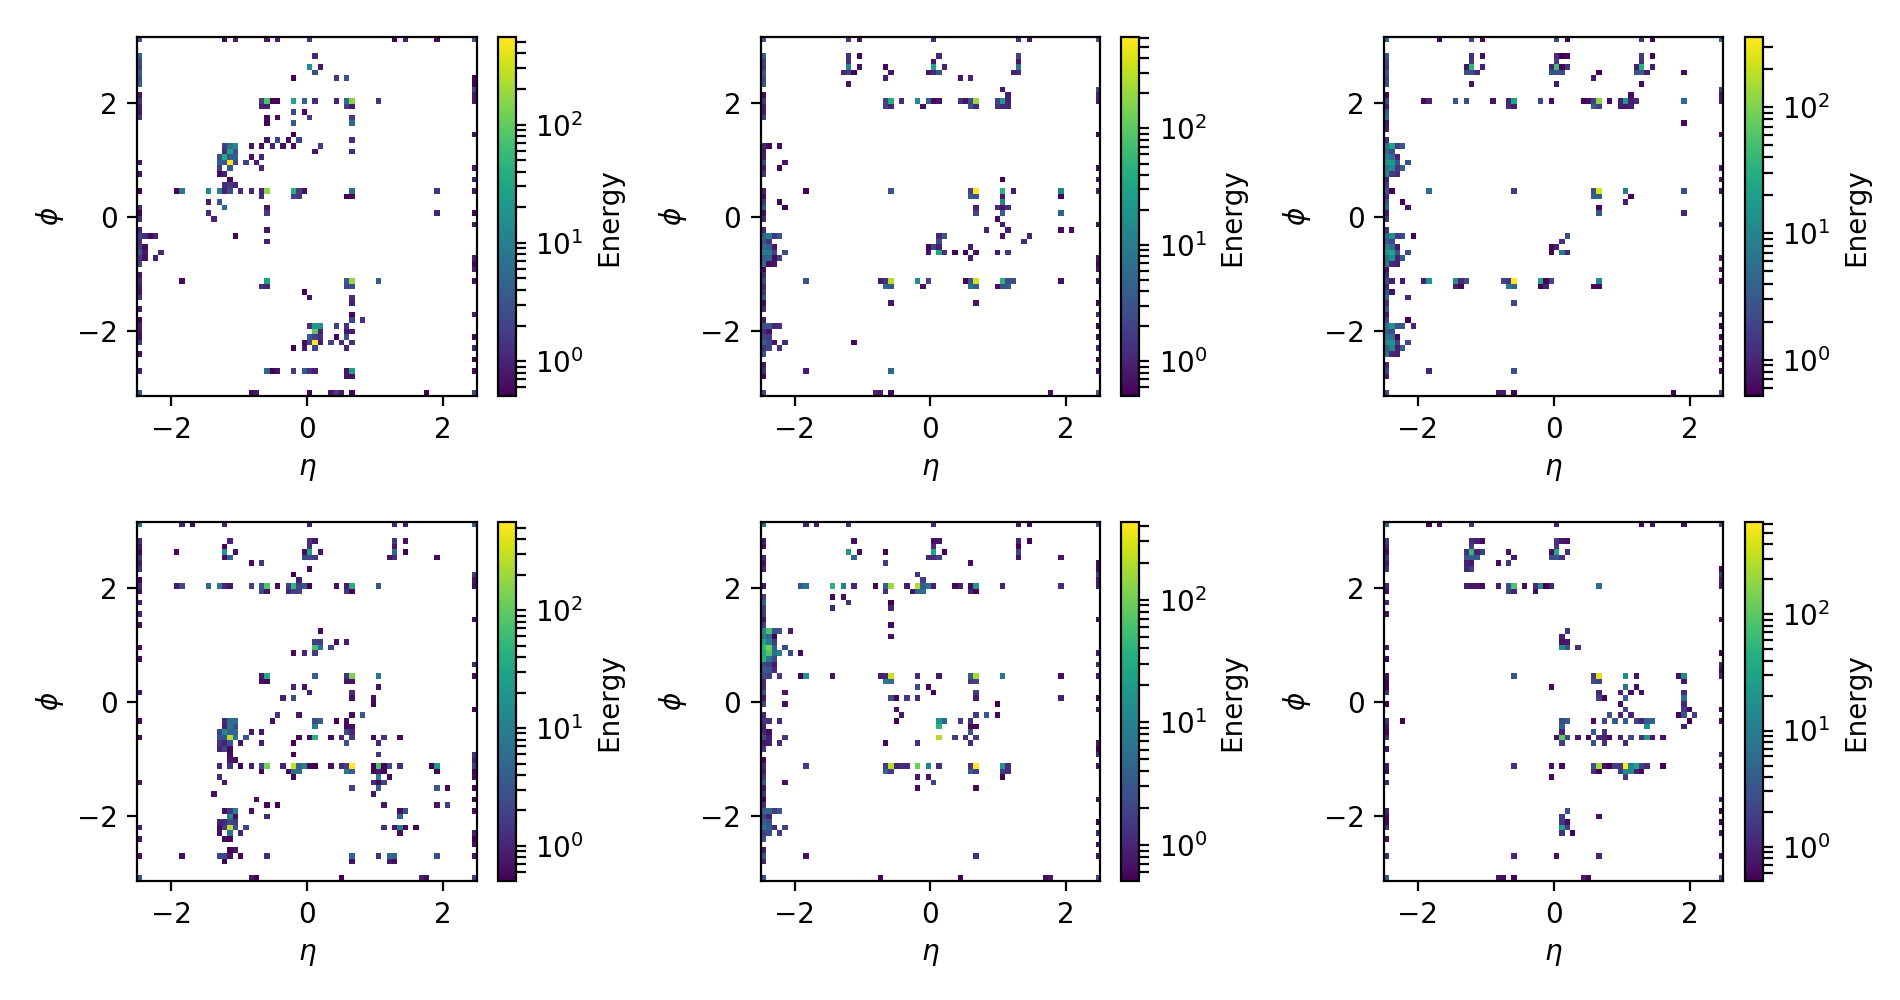

Epoch 8


<IPython.core.display.Javascript object>


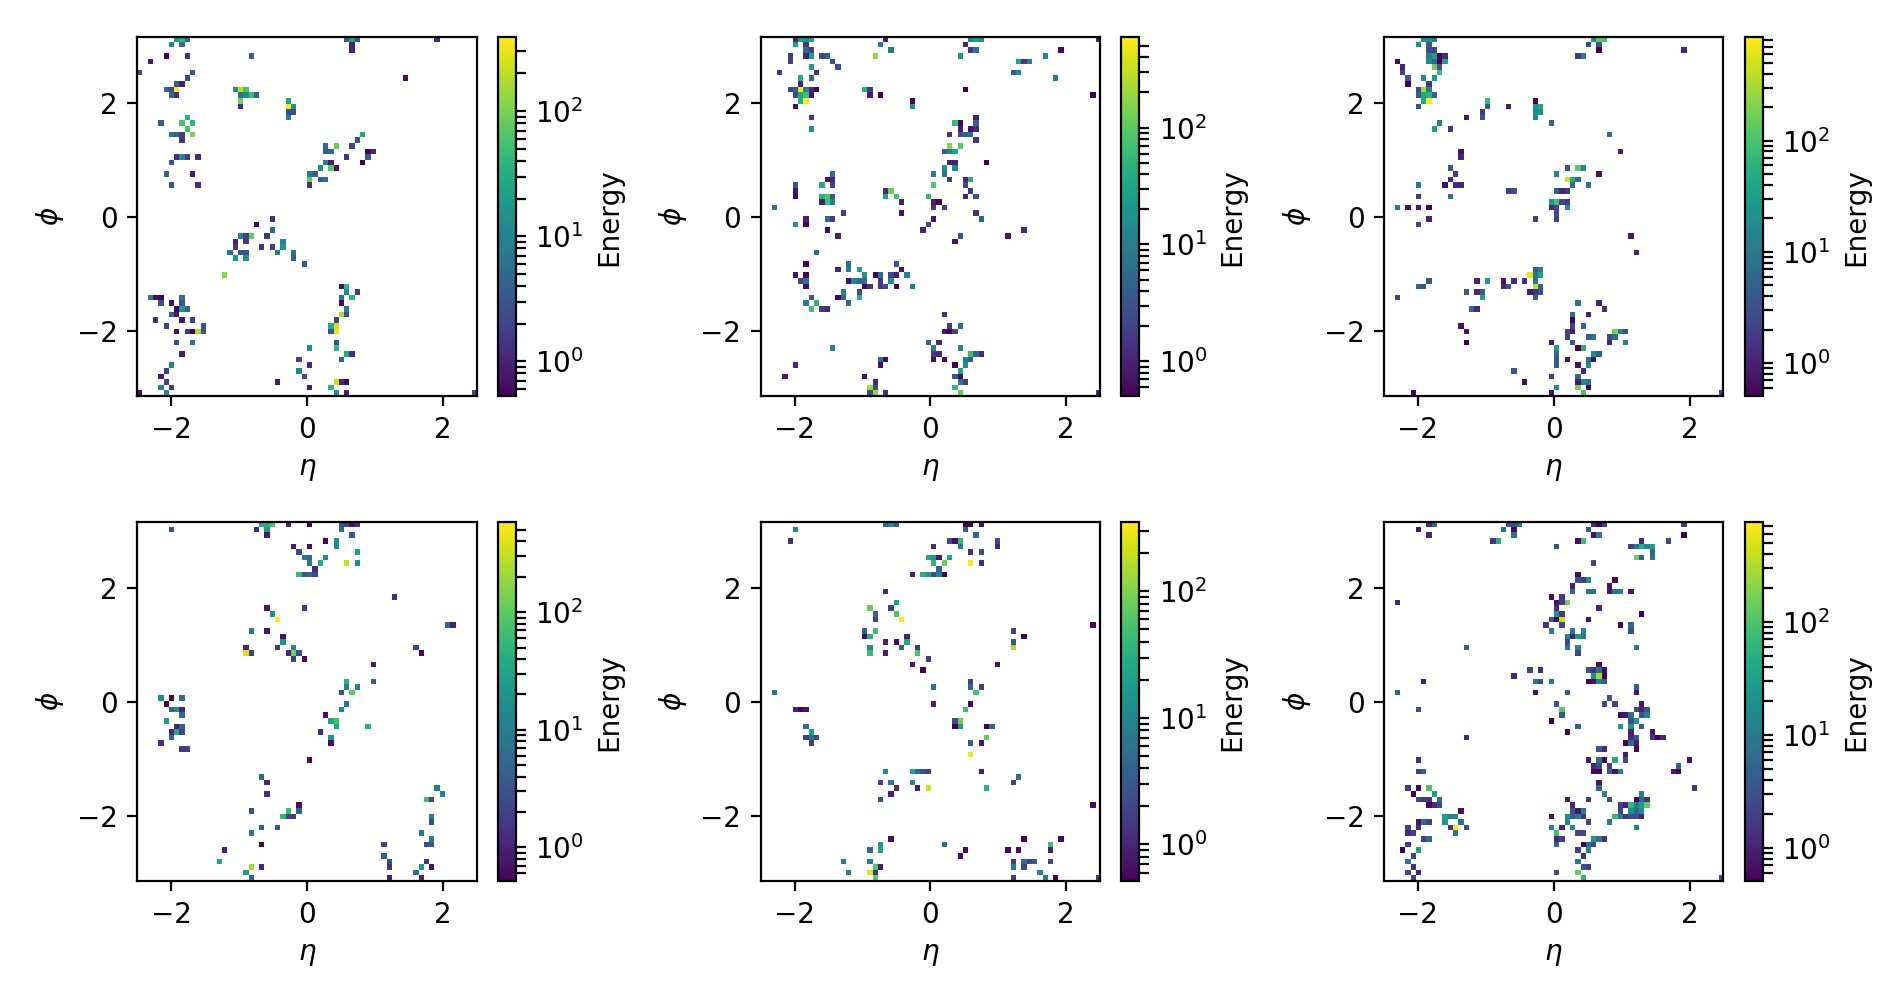

Epoch 10


<IPython.core.display.Javascript object>


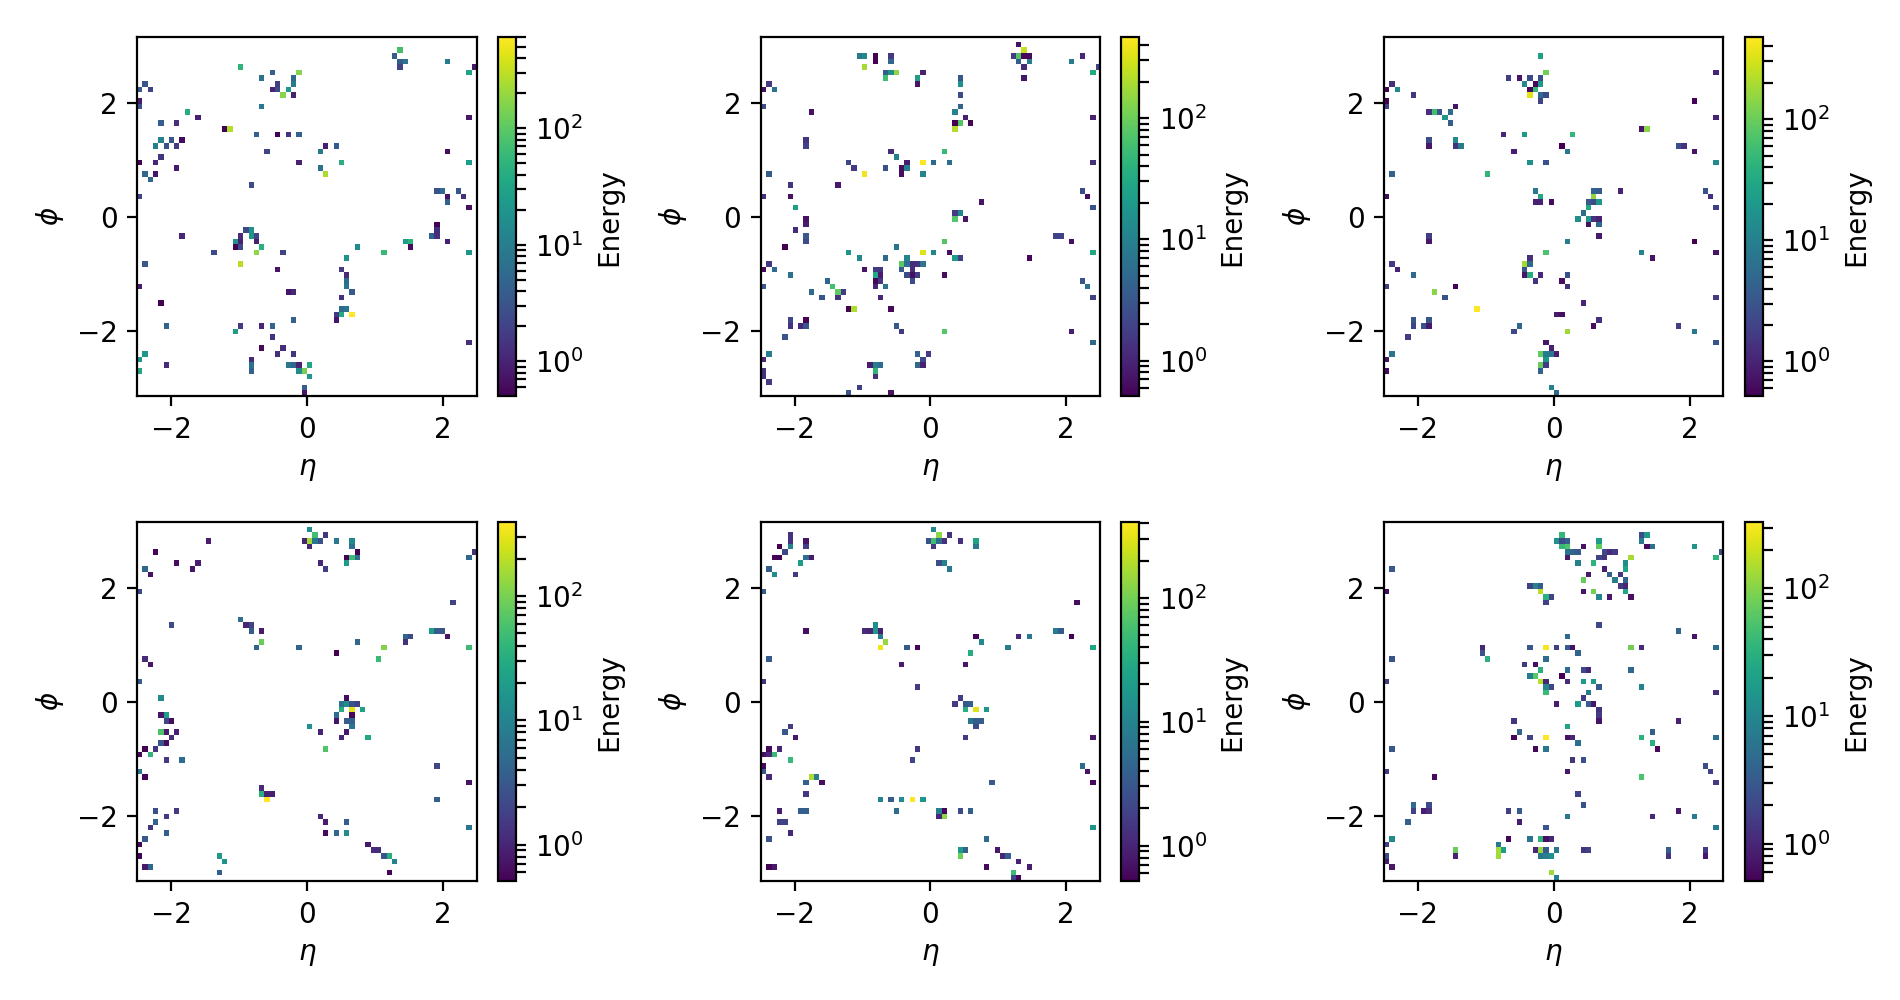

Epoch 31


<IPython.core.display.Javascript object>


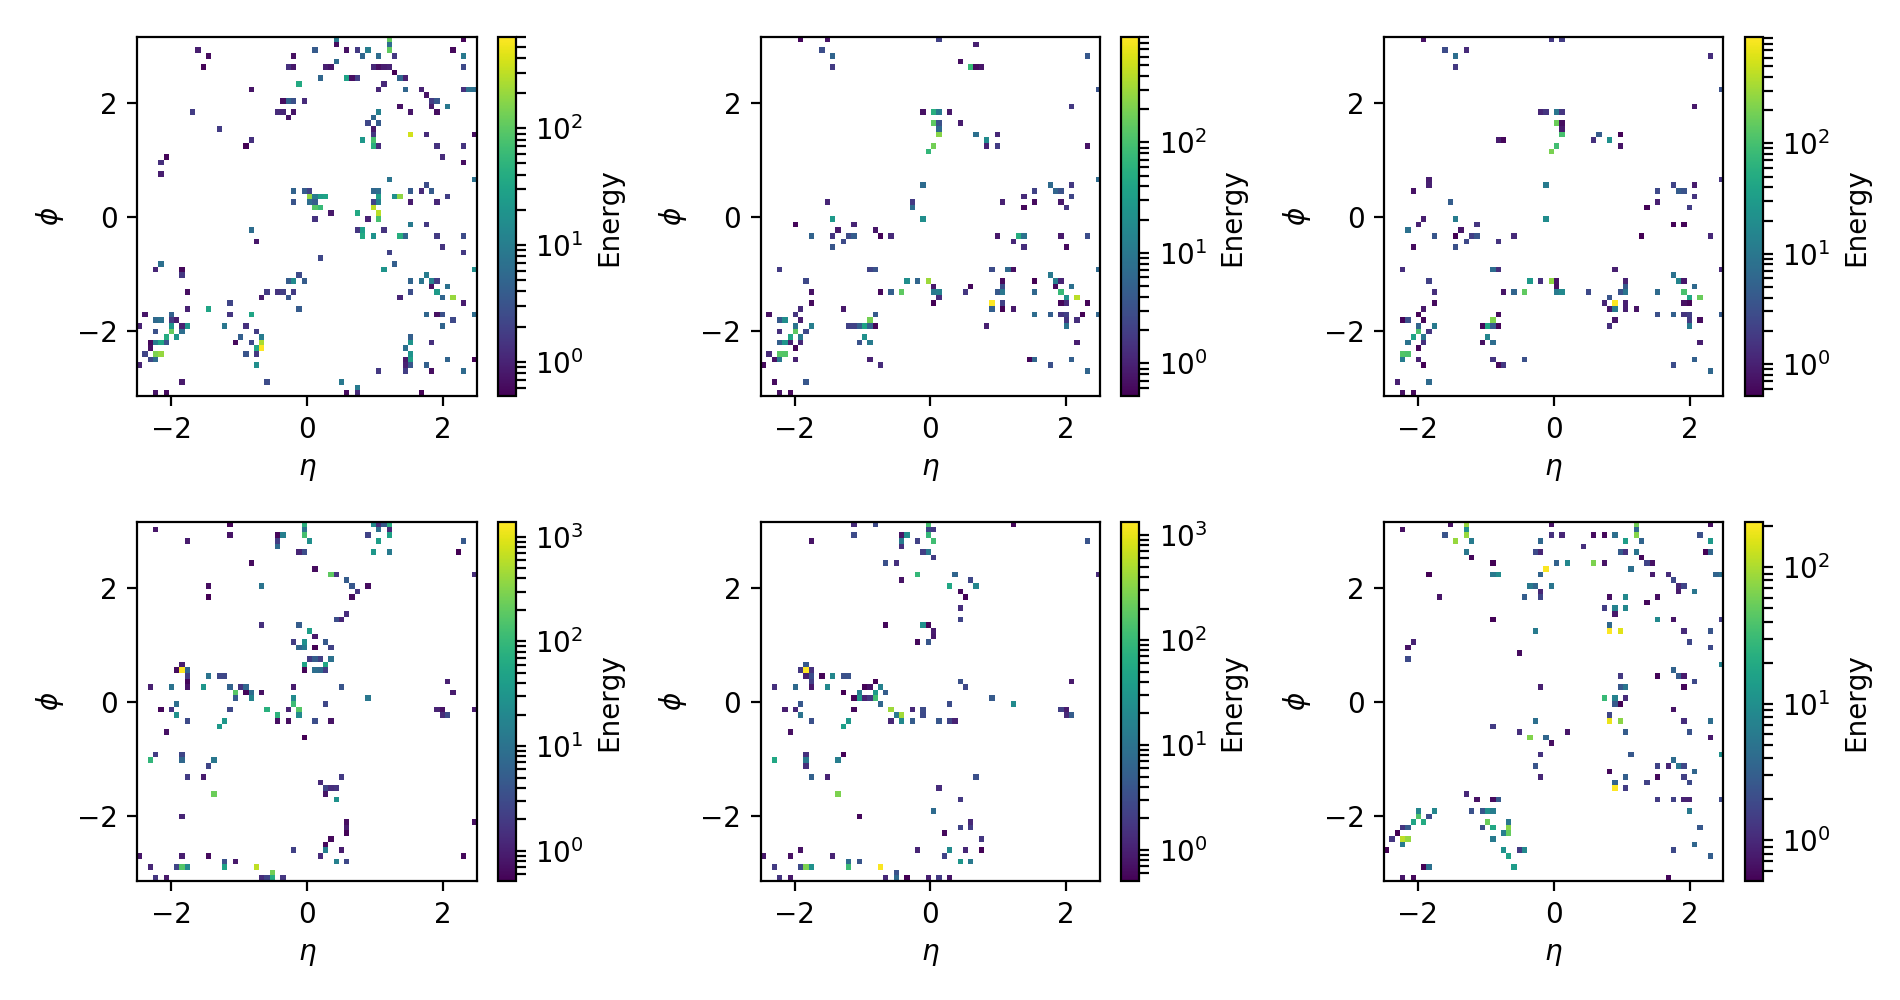

In [35]:
# Fake images from select epochs
select_epochs = [0, 8, 10, 31]
for epoch in select_epochs:
    print('Epoch', epoch)
    gen_images = results['gen_images'][epoch]

    fig, axs = plt.subplots(2, 3, figsize=(9.5, 5))
    for i, ax in enumerate(axs.flatten()):
        draw_image(gen_images[i]*1e-3, ax=ax)
    plt.tight_layout()

## Discussion

The KS metric seems to be a reasonable way to pick out the best distributions. And the summed metric can probably be used to pick out the best model epoch, but one has to choose which distributions to include in it.

The GAN clearly struggles to capture certain things, especially the geometric distribution of the jets.

Also, one can observe funny artifacts in the generated images such as common pixel patterns.